-entrenamos en GBL
-entrenamos en GBL + otros solventes
-testeamos en ambos casos en GBL, no habia cols de solventes

- luego lo encodeamos y repetimos lo mismo
- no vemos que se vea afectada, seguimos igual pero con esa info




In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from src.config import chemical_inventory_path, raw_data_path
from src.data import notebook_utils as utils
from src.constants import GBL_INCHI_KEY, DMSO_INCHI_KEY, DMF_INCHI_KEY, \
                        INCHI_TO_CHEMNAME, TARGET_COL, RXN_FEAT_NAME, ORGANOAMONIUM_INCHI_KEY_COL
from src import plot_utils
from pathlib import Path

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.reload_library()
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns

In [6]:
%cd ../..

/home/belu/VS Workplace/licentiate-thesis-repo


In [7]:
folder_exp_bagging = 'results/ensamble/bagging_validation/'
file_single_estimators = 'results/ensamble/individual_validation/single_estimators_validation.csv'

In [120]:
files = { 
    'DT': 'dtfinal_bagging_estimators.csv',
    'KNN': 'knn_final_bagging_estimators.csv',
    'LG': 'lg_final_bagging_estimators.csv',
    'SVM': 'svm_final_bagging_estimators.csv',
    }

In [174]:
dfs = []
for estimator_name, file in files.items():
    data = pd.read_csv(folder_exp_bagging+file)
    data['estimador'] = estimator_name
    if estimator_name in ['DT', 'KNN']:
        data['tipo'] = 'inestable'
    else:
        data['tipo'] = 'estable'
    dfs.append(data)
df = pd.concat(dfs, axis=0).reset_index()

In [175]:
# correct values
df = df.replace({500:300})

In [13]:
metrics_mean_col = ['mean_test_matthew', 'mean_test_recall','mean_test_precision', 'mean_test_f1']
metrics_plot_name = ['Matthew', 'Recall', 'Precision', 'F1']
metrics_name = {metrics_mean_col[i]: metrics_plot_name[i] for i  in range(len(metrics_mean_col))}

In [177]:
df_single = pd.read_csv(file_single_estimators)
df_single.model = df_single.model.str.upper()
#df_single_out = df_single.groupby('model').mean()[['test_matthew', 'test_recall', 'test_precision', 'test_f1']]

In [178]:
df_single_out = df_single[['test_matthew', 'test_recall', 'test_precision', 'test_f1', 'model']]

In [179]:
df_bagging_1 = df[df.param_model__n_estimators == 300].groupby('estimador').mean()[metrics_mean_col]

In [180]:
df_bagging_1

,mean_test_matthew,mean_test_recall,mean_test_precision,mean_test_f1
estimador,,,,
DT,0.592237,0.616875,0.719327,0.663918
KNN,0.661845,0.687500,0.764776,0.723277
LG,0.370672,0.757500,0.380190,0.506262
SVM,0.111414,0.095000,0.392765,0.151710


In [181]:
df_bagging = df[metrics_mean_col+['estimador', 'param_model__n_estimators']]

In [182]:
df_single_out.columns = metrics_mean_col+['model']

df_single_out['x'] = 335

df_single_out = df_single_out.reset_index(drop=True)

df_single = df_single_out[df_single_out['model'].isin(['DT', 'LG', 'SVM_LINEAR', 'KNN'])]

df_single = df_single.replace({'SVM_LINEAR': 'SVM'})

/home/belu/.local/share/virtualenvs/licentiate-thesis-repo-cz9ujhZI/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [183]:
df_single = df_single.rename({'model':'estimador'}, axis=1)

In [205]:
df_single_bis = df_single.copy()
df_single_bis["x"] = 0

In [212]:
df_single_estimator = pd.concat([df_single, df_single_bis], axis=0).reset_index(drop=True)

In [132]:
sns.set_palette(bright)
sns.palettes.color_palette()

[(0.26666666666666666, 0.4666666666666667, 0.6666666666666666),
 (0.4, 0.8, 0.9333333333333333),
 (0.13333333333333333, 0.5333333333333333, 0.2),
 (0.8, 0.7333333333333333, 0.26666666666666666),
 (0.9333333333333333, 0.4, 0.4666666666666667),
 (0.6666666666666666, 0.2, 0.4666666666666667),
 (0.7333333333333333, 0.7333333333333333, 0.7333333333333333),
 (0.0, 0.0, 0.0)]

In [213]:
sns.set(font_scale = 1.05) 
sns.set_context('paper')
plot_figures_dir = 'figures/ensemble/bagging/'
def plot_bagging(df, metric='mean_test_matthew', plot_name='not_known.pdf'):
    plot_title = plot_figures_dir + plot_name    
    with plt.style.context(['science', 'bright']):
        bright = plot_utils.tol_cset("bright")
        
        ax = sns.lineplot(data=df, x='param_model__n_estimators', y=metric,
                          hue='estimador', legend='brief',
                          marker='o', markersize=4, linestyle='dotted', err_style='band', ci=100
                        )
            #ax.set_yticklabels(rotation=90)
        ax.tick_params(labelbottom=True, which="both", left=False, bottom=False, top=False, right=False)
   
        ax.set(xlabel='N estimadores', ylabel=metrics_name[metric])
        plt.legend(title="", loc='lower right', fontsize='small', ncol=1,
                            framealpha=0.5, fancybox=True, facecolor='white',
                  bbox_to_anchor=(1, 0.1))
        
        for h in ax.legend_.legendHandles: 
            h.set_marker('.')
            h.set_linestyle(":")
    
        plt.xlim(-5,300)
        #plt.ylim(0)

        plt.savefig(plot_title, dpi=300)
        plt.close()
        
    
       #         hue=df['param_model__random_state'])
#plt.legend(loc='upper left')
#plt.savefig('figures/ensemble/bagging/'+bagging_models[1]+file_depth+'.pdf', dpi=300)

In [413]:
def plot_bagging_vs_single(df, df_single, metric='mean_test_matthew', plot_name='not_known.pdf'):
    plot_title = plot_figures_dir + plot_name
    
    with plt.style.context(['science', 'bright']):
        bright = plot_utils.tol_cset("bright")
        colors = [bright.blue, bright.red, bright.green, bright.yellow]
        estimators = ['DT', 'KNN', 'LG', 'SVM']
        palette = dict(zip(estimators, colors))
        
        ax = sns.lineplot(data=df, x='param_model__n_estimators', y=metric,
                          hue='estimador', legend='brief',
                          marker='o', markersize=4, linestyle='', err_style='band', ci=100,
                          palette=palette, err_kws={'alpha':0.38}
                        )
                
        sns.lineplot(ax=ax, data=df_single, x='x', y=metric,
                     hue='estimador', legend=False,
                     marker='.', markersize=1, linestyle='solid', err_style='band', ci=100,
                     palette=palette, err_kws={'alpha':0.12, 'edgecolor':'black', 'linestyle': '--'}, linewidth=0.4, alpha=0.0
                     )


        patches = []
        for name, color in palette.items():
            patches.append(mpatches.Patch(facecolor=color, label=name))
        
        patches.append(Line2D([0], [0], linestyle='dotted', label='Ensamble', 
                              color='white', marker='o', markeredgecolor="black"))
        #patches.append(Line2D([0], [0], linestyle='', label='Simple', marker='',
        #                      color='grey', alpha=0.9))
        patches.append(mpatches.Patch(facecolor='grey', label="Simple", alpha=0.2,
                                      edgecolor='black', linestyle='--'
                                     ))

        legend_1 = plt.legend(handles=patches, loc='lower right',
                            fontsize=10, title="",
                             bbox_to_anchor=(1.5, 0.14))

        #for single_point, color in zip(df_single[metric], colors):
        #    ax.axhline(y=single_point, color=color)
        #sns.scatterplot(ax=ax, data=df_single, y=metric, x='x', hue='estimador', s=50, color=".2", 
        #                marker="d", legend=False)
            #ax.set_yticklabels(rotation=90)
        ax.tick_params(labelbottom=True, which="both", left=False, bottom=False, top=False, right=False)
   
        ax.set(xlabel='N estimadores', ylabel=metrics_name[metric])

    
        plt.xlim(-5,305)
        #plt.ylim(0)
        plt.savefig(plot_title, dpi=300)
        #plt.close()

In [414]:
plot_figures_dir = '../licentiate-thesis-repo/figures/ensemble/bagging/validation/'

        plt.legend(title="", loc='lower right', fontsize='small', ncol=1,
                   framealpha=0.5, fancybox=True, facecolor='white',
                   bbox_to_anchor=(1, 0.8))

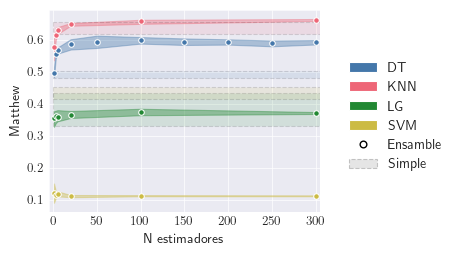

In [415]:
metric_name = 'mean_test_matthew'
plot_bagging_vs_single(df_bagging, df_single_estimator, plot_name='lineplot_%s_vs_single_bagging.pdf' % metric_name)

In [26]:
for metric_name in metrics_mean_col:
#metric_name = 'mean_test_matthew'
    plot_bagging_vs_single(df, df_single, plot_name='lineplot_%s_vs_single_bagging.pdf' % metric_name)

In [28]:
#plot_bagging(df, plot_name='lineplot_%s_bagging.pdf' % metric_name)

In [27]:
#for metric_name in metrics_mean_col:
#metric_name = 'mean_test_matthew'
#    plot_bagging(df, metric=metric_name, plot_name='lineplot_%s_bagging.pdf' % metric_name)

In [ ]:
def exp_1_boxplot_classes(df, plot_name="exp_1_unknown_plot.pdf",
                         bbox_to_anchor=(1.55, 0.97), height=2,
                         aspect=1.5
                         ):
    plot_title = "figures/solvent/"+plot_name
    with plt.style.context(['science', 'bright']):
        bright = plot_utils.tol_cset("bright")
        g = sns.catplot(x="Métrica", y="Score",
                    hue="Tipo", height=height, aspect=aspect,
                    #row='Clase',
                    col='Solvente',
                    #col_order=["Cristaliza", "No cristaliza"], 
                    palette=[bright.red, bright.grey],
                    kind='box', sharey=False, sharex=True, data=df, legend=False)
        for ax in g.axes[0]:
            #ax.set_xticklabels(['A', 'B', 'C'], rotation=0)
            ax.tick_params(labelbottom=True, which="both", left=False, bottom=False, 
                           top=False, right=False)
        g.set(xlabel=None)
        
        pop_a = mpatches.Patch(facecolor=bright.red, label="ENCODED_SV", edgecolor='grey')
        pop_b = mpatches.Patch(facecolor=bright.grey, label="SIN_SV", edgecolor='grey')
        plt.legend(handles=[pop_a,pop_b])
        #g._legend.set_title(" ")
        plt.legend(fontsize=11, loc='lower right', bbox_to_anchor=bbox_to_anchor)
        #plt.setp(g._legend.get_texts(), fontsize='10')
        #g.savefig(plot_title, dpi=300)

In [8]:
file_single_estimators

'results/ensamble/individual_validation/single_estimators_validation.csv'

In [15]:
metrics_name

{'mean_test_matthew': 'Matthew',
 'mean_test_recall': 'Recall',
 'mean_test_precision': 'Precision',
 'mean_test_f1': 'F1'}

In [61]:
df_val_class = pd.read_csv(file_single_estimators)

In [72]:
models = ['dt', 'knn', 'lg', 'svm_linear', 'rf', 'gbc']

cols_ensemble = {'test_recall_0': 'Recall Clase Mayoritaria',
                 'test_recall_1': 'Recall Clase Minoritaria',
                 'test_matthew': 'Matthew'
                }

preference_class = {'dt': '-',
                    'knn': 'Mayoritaria',
                    'lg': '-',
                    'svm_linear': 'Minoritaria',
                    'rf': '-',
                    'gbc': 'Mayoritaria'
                   }

In [73]:
df_val = df_val_class[df_val_class['model'].isin(models)]

In [74]:
df_val_mean = df_val.groupby('model').mean()

In [75]:
df_val_mean['Preferencia'] = df_val_mean.index.map(preference_class)

In [86]:
df_class_plot = df_val_mean.rename(cols_ensemble, axis=1)[['Preferencia']+list(cols_ensemble.values())]

In [87]:
df_class_plot.round(2).sort_values('Preferencia')

,Preferencia,Recall Clase Mayoritaria,Recall Clase Minoritaria,Matthew
model,,,,
dt,-,0.75,0.84,0.49
lg,-,0.69,0.79,0.38
rf,-,0.77,0.85,0.52
gbc,Mayoritaria,0.95,0.64,0.64
knn,Mayoritaria,0.94,0.68,0.64
svm_linear,Minoritaria,0.64,0.91,0.44


In [22]:
df.rename(cols_ensemble).groupby('model').mean()[cols_ensemble.keys()].sort_values('test_matthew')

,test_recall_0,test_recall_1,test_matthew
model,,,
lg,0.687092,0.786667,0.383668
svm_linear,0.638889,0.910000,0.437756
dt,0.754085,0.836667,0.490252
svm_poly,0.720588,0.893333,0.498376
rf,0.769608,0.853333,0.518352
svm_rbf,0.745915,0.903333,0.531425
gbc,0.953431,0.640000,0.638339
knn,0.941993,0.676667,0.640846


In [1]:
results_path = 'results/ensamble/indi'

In [ ]:
single_ensemble = results_path+'single+ensemble_vs_voting.csv'
single_robust = results_path+'single_svm_knn_gbc_vs_voting.csv'

single_voting = results_path+'single_svm_knn_vs_voting.csv'
all_svm_con_gbc = results_path+'all_svm_con_gbc.csv'
all_svm_con_gbc_rf = results_path+'all_svm_con_gbc_rf.csv'